In [1]:
#ignore annoying deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# K-Means Clustering in Python!

## Introduction

**K-means clustering** is an unsupervised learning algorithm that can subdivide a data set into *k* clusters by automatically learning the relationships among the variables appearing in the data set. The k-means algorithm assigns each case to the cluster whose mean location is closest to the location of the case being considered. Specifcally, given an initial set of *k* cluster means, the algorithm proceeds by alternating between two steps:
1. **Assignment step**: Assign each case to the cluster whose mean is nearest to the current case.
2. **Update step**: Calculate the new mean (i.e., centroids) for each cluster based on the cases that are currently assigned to that cluster.

The algorithm is finished when the cluster assignments no longer change from one iteration of the algorithm to the next.


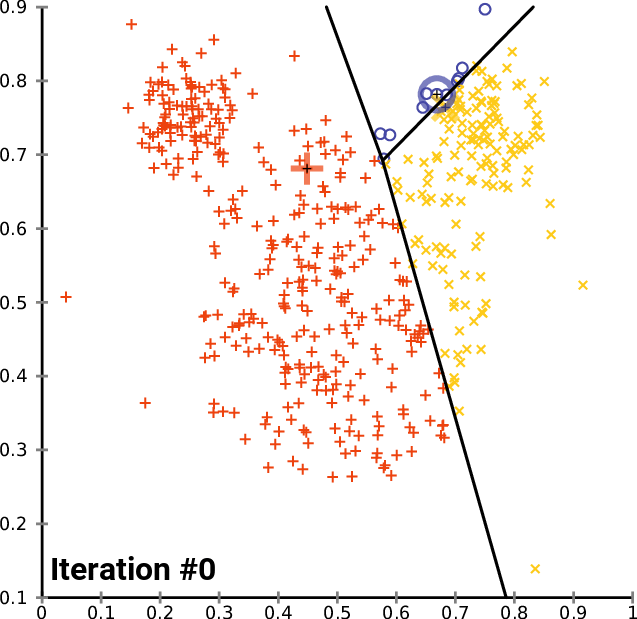

## Import Packages and Load Data

In this lesson, we'll learn how to implement k-means clustering in Python by using the `KMeans` function from within the scikit-learn *cluster* package. The data set for this lesson consists of 13 variables that describe different properties of 178 different wines. All of the wines were made from grapes that were grown in the same region in Italy, with each wine being derived from one of three different cultivars or varieties of grape plants. We will see how well the k-means algorithm can accurately identify the cultivar from which each wine was made *without ever seeing any information about the cultivars themselves*:

In [2]:
#import packages
import sklearn.datasets as datasets
from sklearn.cluster import KMeans
import pandas as pd

#load the wine data set into a pandas dataframe, and assign column names
features, cultivars = datasets.load_wine(return_X_y = True)
df = pd.DataFrame(features)
df.columns = ['Alcohol', 'Malic_Acid', 'Ash', 'Alkalinity_of_Ash', 'Magnesium', 'Total_Phenols', 'Flavonoids', 'Nonflavonoid_Phenols', 'Proanthocyanidins', 'Color_Intensity', 'Hue', 'Proteins', 'Proline']
df['Cultivar_Name'] = cultivars

#replace numeric cultivar codes with textual labels
cultivar_names = { 0 : 'Cultivar A', 1 : 'Cultivar B', 2 : 'Cultivar C' }
df['Cultivar_Name'].replace(cultivar_names, inplace = True)

#show the first few rows of data
df.head()

Alcohol  Malic_Acid   Ash  Alkalinity_of_Ash  Magnesium  Total_Phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   Flavonoids  Nonflavonoid_Phenols  Proanthocyanidins  Color_Intensity   Hue  \
0        3.06                  0.28               2.29             5.64  1.04   
1        2.76                  0.26               1.28             4.38  1.05   
2        3.24                  0.30               2.81             5.68  1.03   
3        3.49                  0.24               2.18             7.80  0.86   
4        2.69                  0.39               1.82             4.32  1.04   

   Proteins  Proline Cultivar_Name  
0      3.92   1065.0    Cultivar A  
1      3.40   1050.0    Cultivar A  
2      3.17   1185.0    Cultivar A  
3      3.45   1480.0    Cultivar A  
4      2.93    735.0    Cultivar A

In [3]:
#examine the cultivars
df.Cultivar_Name.value_counts()

Cultivar B    71
Cultivar A    59
Cultivar C    48
Name: Cultivar_Name, dtype: int64

## Standardize the Input Features

Since k-means clustering uses a distance-based approach to assigning raw cases to clusters, it is important that we standardize all of our variables to ensure that each variable has the same distributional properties. If we did not standardize the variables, then those variables that had smaller levels of variance would be given more weight or influence than variables with greater levels of variance.

The Python code below transforms the values of all of the input variables into standard scores (i.e., z-scores):

In [4]:
#standardize all of the input features into z-scores
for col_name in df.columns[:-1]:
    mean = df[col_name].mean()
    std = df[col_name].std()
    df[col_name] = [(x - mean) / std for x in df[col_name]]

#show descriptive statistics
df.describe().transpose()

count          mean  std       min       25%       50%  \
Alcohol               178.0  7.823954e-15  1.0 -2.427388 -0.786027  0.060828   
Malic_Acid            178.0  2.943962e-16  1.0 -1.428952 -0.656896 -0.421922   
Ash                   178.0 -4.082876e-15  1.0 -3.668813 -0.570513 -0.023754   
Alkalinity_of_Ash     178.0 -5.488743e-17  1.0 -2.663505 -0.687199  0.001514   
Magnesium             178.0 -7.609394e-17  1.0 -2.082381 -0.822096 -0.121938   
Total_Phenols         178.0  1.234967e-16  1.0 -2.101318 -0.882977  0.095690   
Flavonoids            178.0  9.580351e-16  1.0 -1.691200 -0.825211  0.105851   
Nonflavonoid_Phenols  178.0 -1.635396e-15  1.0 -1.862979 -0.738059 -0.175599   
Proanthocyanidins     178.0 -1.666270e-15  1.0 -2.063214 -0.595603 -0.062721   
Color_Intensity       178.0 -4.216353e-16  1.0 -1.629691 -0.792866 -0.158777   
Hue                   178.0  1.657850e-15  1.0 -2.088840 -0.765403  0.033034   
Proteins              178.0  2.200487e-15  1.0 -1.889723 -0.949570  0.237066   
Proline               178.0 -1.341000e-16  1.0 -1.488987 -0.782431 -0.233063   

                           75%       max  
Alcohol               0.833777  2.253415  
Malic_Acid            0.667909  3.100446  
Ash                   0.696145  3.147447  
Alkalinity_of_Ash     0.600395  3.145637  
Magnesium             0.508205  4.359076  
Total_Phenols         0.806722  2.532372  
Flavonoids            0.846697  3.054216  
Nonflavonoid_Phenols  0.607827  2.395645  
Proanthocyanidins     0.627406  3.475269  
Color_Intensity       0.492567  3.425768  
Hue                   0.711158  3.292407  
Proteins              0.786369  1.955399  
Proline               0.756117  2.963114

## Define and Run the K-Means Clustering Model

Our next step is to define and run the k-means clustering model. For this purpose, we'll use the `KMeans` function from the scikit-learn *cluster* package. We'll then get the ID numbers of the cultivar cluster to which the k-means algorithm has assigned each of the wines in our data set:

In [5]:
#define the k-means clustering model, and get cluster assignments for each case
kmeans_mod = KMeans(n_clusters = 3, random_state = 0)
cluster_ids = kmeans_mod.fit_predict(df.iloc[:, :-1])

#add the cluster assignments to the dataframe
df['Cluster_Id'] = cluster_ids

#show cultivar names and cluster assignments
df[['Cultivar_Name', 'Cluster_Id']]

Cultivar_Name  Cluster_Id
0      Cultivar A           2
1      Cultivar A           2
2      Cultivar A           2
3      Cultivar A           2
4      Cultivar A           2
5      Cultivar A           2
6      Cultivar A           2
7      Cultivar A           2
8      Cultivar A           2
9      Cultivar A           2
10     Cultivar A           2
11     Cultivar A           2
12     Cultivar A           2
13     Cultivar A           2
14     Cultivar A           2
15     Cultivar A           2
16     Cultivar A           2
17     Cultivar A           2
18     Cultivar A           2
19     Cultivar A           2
20     Cultivar A           2
21     Cultivar A           2
22     Cultivar A           2
23     Cultivar A           2
24     Cultivar A           2
25     Cultivar A           2
26     Cultivar A           2
27     Cultivar A           2
28     Cultivar A           2
29     Cultivar A           2
..            ...         ...
148    Cultivar C           0
149    Cultivar C           0
150    Cultivar C           0
151    Cultivar C           0
152    Cultivar C           0
153    Cultivar C           0
154    Cultivar C           0
155    Cultivar C           0
156    Cultivar C           0
157    Cultivar C           0
158    Cultivar C           0
159    Cultivar C           0
160    Cultivar C           0
161    Cultivar C           0
162    Cultivar C           0
163    Cultivar C           0
164    Cultivar C           0
165    Cultivar C           0
166    Cultivar C           0
167    Cultivar C           0
168    Cultivar C           0
169    Cultivar C           0
170    Cultivar C           0
171    Cultivar C           0
172    Cultivar C           0
173    Cultivar C           0
174    Cultivar C           0
175    Cultivar C           0
176    Cultivar C           0
177    Cultivar C           0

[178 rows x 2 columns]

## Evaluate the Performance of the K-Means Model

Finally, we can evaluate the performace of our k-means model by comparing the clusters to which each of the wines was assigned with the true grape plant cultivar from which each wine was actually made:

In [6]:
#show number of cases assigned to each cluster for each cultivar
for cultivar_name in df['Cultivar_Name'].unique():
    print(cultivar_name + ':')
    cultivar_cases = df[df['Cultivar_Name'] == cultivar_name]
    print(cultivar_cases['Cluster_Id'].value_counts())

Cultivar A:
2    59
Name: Cluster_Id, dtype: int64
Cultivar B:
1    66
0     3
2     2
Name: Cluster_Id, dtype: int64
Cultivar C:
0    48
Name: Cluster_Id, dtype: int64


Recall from earlier in this lesson that the number of cases for each cultivar was:
* Cultivar A: 59 cases
* Cultivar B: 71 cases
* Cultivar C: 48 cases

As shown in the output above, the k-means clustering algorithm assigned all 59 cases of *Cultivar A* to cluster 2, and all 48 cases of *Cultivar C* to cluster 0. Among the 71 cases of *Cultivar B*, 66 cases were correctly assigned to cluster 1, while 5 cases were assigned to incorrect clusters (i.e., 3 cases were assigned to cluster 0, and 2 cases were assigned to cluster 2). The k-means clustering algorithm was thus able to currectly differentiate among the three cultivars with **97.2%** accuracy. Put differently, the k-means clustering algorithm was able to correctly classify 97.2% of the cases ***without having seen any information about the true cultivars from which each wine was actually made***. This is a hallmark feature of unsupervised learning algorithms such as k-means clustering -- they learn the relationships among the elements in a data set and classify the raw data without any help or feedback from a training process!